In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential


/Users/imangill/Desktop/DIS/HEP/igf23/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def rotate_kernel_90(kernel, k):
    kernel_transposed = tf.transpose(kernel, perm=[2, 0, 1, 3])
    rotated = tf.image.rot90(kernel_transposed, k=k)
    rotated_kernel = tf.transpose(rotated, perm=[1, 2, 0, 3])
    return rotated_kernel


class RotationEquivariantConv(layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

    def build(self, input_shape):
        # input_shape is [batch_size, H, W, channels_in]
        channels_in = input_shape[-1]
        # base kernel shape [kernel_size, kernel_size, channels_in, filters]
        self.base_kernel = self.add_weight(
            shape=(self.kernel_size, self.kernel_size, channels_in, self.filters),
            initializer='he_normal',
            trainable=True,
            name='base_kernel'
        )
        # bias term
        self.bias = self.add_weight(
            shape=(self.filters,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )
        super().build(input_shape)

    def call(self, inputs):
        # Rotate the kernel by 0, 90, 180, 270 degrees
        kernel_0   = self.base_kernel
        kernel_90  = rotate_kernel_90(kernel_0, k =1)
        kernel_180 = rotate_kernel_90(kernel_90, k =1)
        kernel_270 = rotate_kernel_90(kernel_180, k =1)

        # Convolve input with each rotated kernel
        conv_0   = tf.nn.conv2d(inputs, kernel_0,
                                strides=1, padding='SAME')
        conv_90  = tf.nn.conv2d(inputs, kernel_90,
                                strides=1, padding='SAME')
        conv_180 = tf.nn.conv2d(inputs, kernel_180,
                                strides=1, padding='SAME')
        conv_270 = tf.nn.conv2d(inputs, kernel_270,
                                strides=1, padding='SAME')

        # Combine them; for equivariance, stack along channels:
        # shape: [batch, H, W, 4*filters]
        combined = tf.concat([conv_0, conv_90, conv_180, conv_270], axis=-1)


        combined += tf.concat([self.bias[None,None,None,:]]*4, axis=-1)

        return combined


In [3]:
def check_equivariance(layer, input_tensor):
    # Compute output for original input.
    Y = layer(input_tensor)
    
    # Rotate the input by 90 degrees.
    x_rotated = tf.image.rot90(input_tensor, k=1)
    Y_rotated = layer(x_rotated)
    
    # The layer output is assumed to have 4 groups: [F0, F90, F180, F270]
    # where each group has 'filters' channels.
    num_groups = 4
    filters = Y.shape[-1] // num_groups
    F0, F90, F180, F270 = tf.split(Y, num_or_size_splits=num_groups, axis=-1)

    F0_exp = tf.image.rot90(F270, k=1)
    F90_exp = tf.image.rot90(F0, k=1)
    F180_exp = tf.image.rot90(F90, k=1)
    F270_exp = tf.image.rot90(F180, k=1)
    
    Y_expected = tf.concat([F0_exp, F90_exp, F180_exp, F270_exp], axis=-1)
    
    # Compute the mean absolute difference between the rotated output and expected output.
    diff = tf.reduce_mean(tf.abs(Y_rotated - Y_expected))
    return diff.numpy()

dummy_input = tf.random.uniform((1, 28, 28, 1))
layer = RotationEquivariantConv(filters=8, kernel_size=3)

passing = True
_ = layer(dummy_input) #Initialize the layer, outside the loop for performance
for i in range(1000):
    dummy_input = tf.random.uniform((1, 28, 28, 1))
    difference = check_equivariance(layer, dummy_input)
    if difference > 1e-7:
        print(f"Equivariance check failed with difference: {difference}")
        passing = False
        break
if passing:
    print("Equivariance check passed!")

Equivariance check passed!


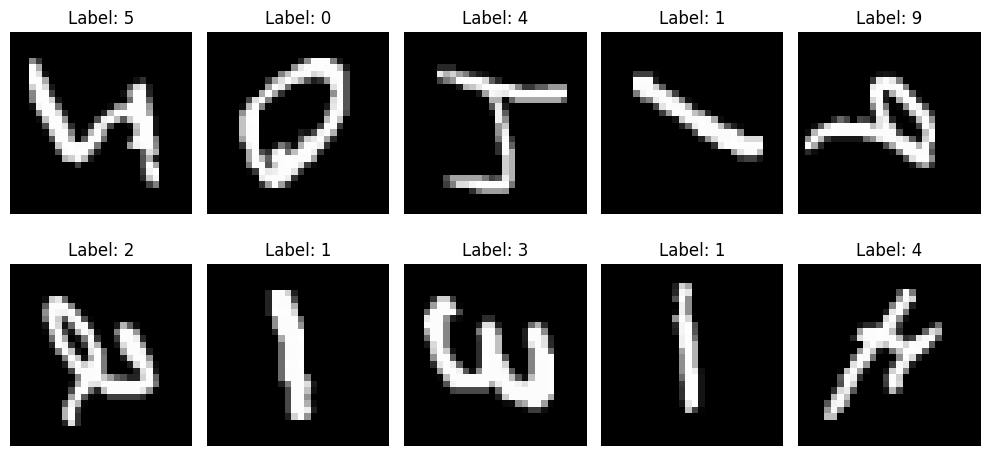

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize
x_train = x_train / 255.
x_test  = x_test / 255.

# Expand dims to have a channel dimension: [N, 28, 28, 1]
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

# Randomly rotate by 0, 90, 180, or 270 for both train and test
def random_rotate(x):
    k = np.random.randint(0, 4)
    return np.rot90(x, k, axes=(0,1))  # rotate in the 2D plane

for i in range(len(x_train)):
    x_train[i] = random_rotate(x_train[i])
for i in range(len(x_test)):
    x_test[i] = random_rotate(x_test[i])

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
eqv_model = tf.keras.Sequential([
    RotationEquivariantConv(filters=8, kernel_size=3, input_shape=(28, 28, 1)),
    layers.ReLU(),
    layers.AveragePooling2D(pool_size=(2, 2)),
    RotationEquivariantConv(filters=16, kernel_size=3),
    layers.ReLU(),
    layers.AveragePooling2D(pool_size=(2, 2)),
    # Flatten + Dense heads
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

eqv_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

eqv_model.summary()

/var/folders/50/yzx_7srn6kg7pvy80vjm6qww0000gn/T/ipykernel_98799/1568765728.py:10: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rotation_equivariant_conv_1     │ (None, 28, 28, 32)     │            80 │
│ (RotationEquivariantConv)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rotation_equivariant_conv_2     │ (None, 14, 14, 64)     │         4,624 │
│ (RotationEquivariantConv)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 7, 7, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,122 (805.16 KB)

 Trainable params: 206,122 (805.16 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
baseline_model = Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
    ], name="BaselineMLP")

baseline_model.summary()

baseline_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/Users/imangill/Desktop/DIS/HEP/igf23/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "BaselineMLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,058 (851.79 KB)

 Trainable params: 218,058 (851.79 KB)

 Non-trainable params: 0 (0.00 B)


Training Equivariant Model...
Epoch 1/5
  1/422 ━━━━━━━━━━━━━━━━━━━━ 6:10 879ms/step - accuracy: 0.1484 - loss: 2.3055

W0000 00:00:1744726653.341297 8195945 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/sequential_1/rotation_equivariant_conv_1_1/rot90_2/Assert/AssertGuard/branch_executed/_81


421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6879 - loss: 0.9488

W0000 00:00:1744726666.772498 8195945 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/sequential_1/rotation_equivariant_conv_1_1/rot90_2/Assert/AssertGuard/branch_executed/_63


422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.6885 - loss: 0.9471 - val_accuracy: 0.9327 - val_loss: 0.2381
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.9189 - loss: 0.2620 - val_accuracy: 0.9540 - val_loss: 0.1631
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9473 - loss: 0.1721 - val_accuracy: 0.9537 - val_loss: 0.1545
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9594 - loss: 0.1296 - val_accuracy: 0.9680 - val_loss: 0.1114
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9680 - loss: 0.1028 - val_accuracy: 0.9685 - val_loss: 0.1037

Training Baseline Model...
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6445 - loss: 1.0989 - val_accuracy: 0.9117 - val_loss: 0.3213
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9030 - loss: 0.3291 - val_accuracy: 0.9377 - val_loss: 0.2143
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9381 - loss: 0.209

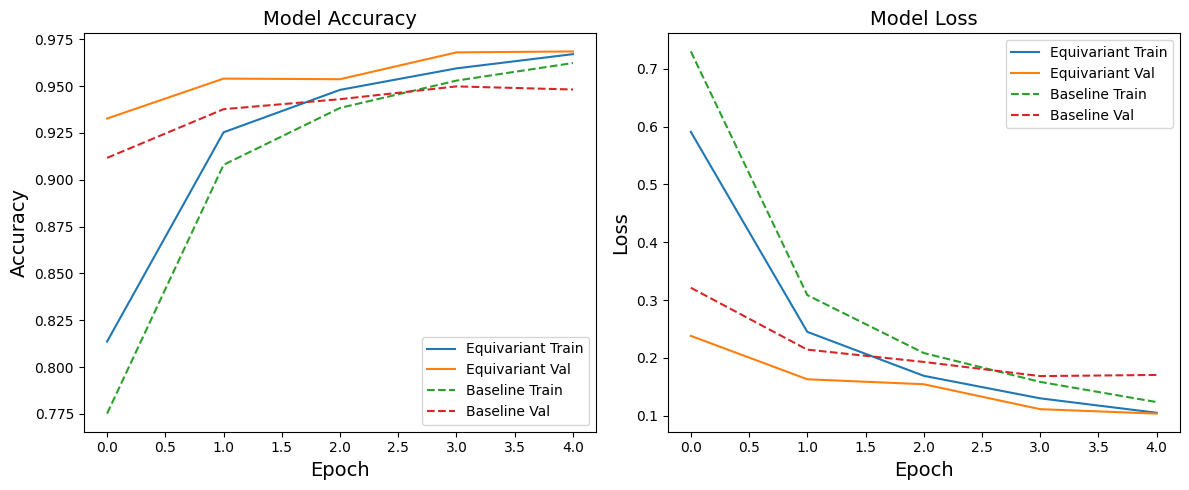

In [7]:
# Compile models
eqv_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Train equivariant model
print("\nTraining Equivariant Model...")
equivariant_history = eqv_model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# Train baseline model
print("\nTraining Baseline Model...")
baseline_history = baseline_model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# Evaluate models
print("\nEvaluating Equivariant Model...")
equivariant_loss, equivariant_acc = eqv_model.evaluate(x_test, y_test)
print(f"Equivariant Model - Test Accuracy: {equivariant_acc:.4f}")

print("\nEvaluating Baseline Model...")
baseline_loss, baseline_acc = baseline_model.evaluate(x_test, y_test)
print(f"Baseline Model - Test Accuracy: {baseline_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(equivariant_history.history['accuracy'], label='Equivariant Train')
plt.plot(equivariant_history.history['val_accuracy'], label='Equivariant Val')
plt.plot(baseline_history.history['accuracy'], label='Baseline Train', linestyle='--')
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Val', linestyle='--')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(equivariant_history.history['loss'], label='Equivariant Train')
plt.plot(equivariant_history.history['val_loss'], label='Equivariant Val')
plt.plot(baseline_history.history['loss'], label='Baseline Train', linestyle ='--')
plt.plot(baseline_history.history['val_loss'], label='Baseline Val', linestyle='--')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()


